In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from scipy.integrate import odeint
from numba import njit

from rodeo.jax.ibm_init import ibm_init
from rodeo.jax.ibm_bridge_init import *
from rodeo.jax.ode_solve import *
import rodeo.jax.ode_bridge_solve as bsol
import ode_forward as osol

from jax.config import config
config.update("jax_enable_x64", True)

o = 10.
def ode_fun_jax(X_t, t, theta):
    "FitzHugh-Nagumo ODE."
    a, b, c = theta
    V, R = X_t[:,0]
    return jnp.array([[c*(V - V*V*V/3 + R)],
                    [-1/c*(V - a + b*R)]])


In [27]:
# problem setup and intialization
n_deriv = 1  # Total state
n_dim = 2  # Total measures
n_deriv_prior = 3

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 400
tmin = 0.
tmax = 40.
tseq = np.linspace(tmin, tmax, n_eval+1)
theta = np.array([0.2, 0.2, 3])
thetaj = jnp.array(theta)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = 1
sigma = jnp.array([sigma]*n_dim)

# Initial value, x0, for the IVP
W_mat = np.zeros((n_dim, 1, n_deriv_prior))
W_mat[:, :, 1] = 1
W_block = jnp.array(W_mat)

# Initial x0 for odeint
ode0 = np.array([-1., 1.])

# Initial x0 for jax block
#x0_block = jnp.array([[-1., 1., 1.], [1., 1/3, -0.3555555555555555]])
x0_block = jnp.array([[-1., 1., 0.], [1., 1/3, 0.]])


# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
n_order = jnp.array([n_deriv_prior]*n_dim)
ode_init = ibm_init(dt, n_order, sigma)
# ode_init['mu_state']= jnp.concatenate([jax.random.normal(key,shape=(2,1)), jnp.zeros((2,2))], axis=1)
# ode_init['mu_state'] = jnp.zeros((2,3))

key = jax.random.PRNGKey(0)
sim_jit = jax.jit(osol.solve_forward, static_argnums=(1, 6, 11))
sim = sim_jit(key=key, fun=ode_fun_jax,
        x0=x0_block, theta=thetaj,
        tmin=tmin, tmax=tmax, n_eval=n_eval,
        wgt_meas=W_block, **ode_init, interrogate=interrogate_schober)

In [22]:
def fitz0(X_t, t, theta):
    a, b, c = theta
    V, R = X_t 
    return np.array([c*(V - V*V*V/3 + R), -1/c*(V - a + b*R)])


In [28]:
from scipy.integrate import odeint
import numpy as np
n_obs = 400
tseq1 = np.linspace(tmin, tmax, n_obs+1)
exact = odeint(fitz0, ode0, tseq1, args=(theta,))
#der = jnp.array([fitz0(exact[t],tseq[t],theta) for t in range(n_eval+1)])

In [29]:
gamma = .2
e_t = np.random.default_rng(0).normal(loc=0.0, scale=1, size=exact.shape)
obs = exact + gamma*e_t

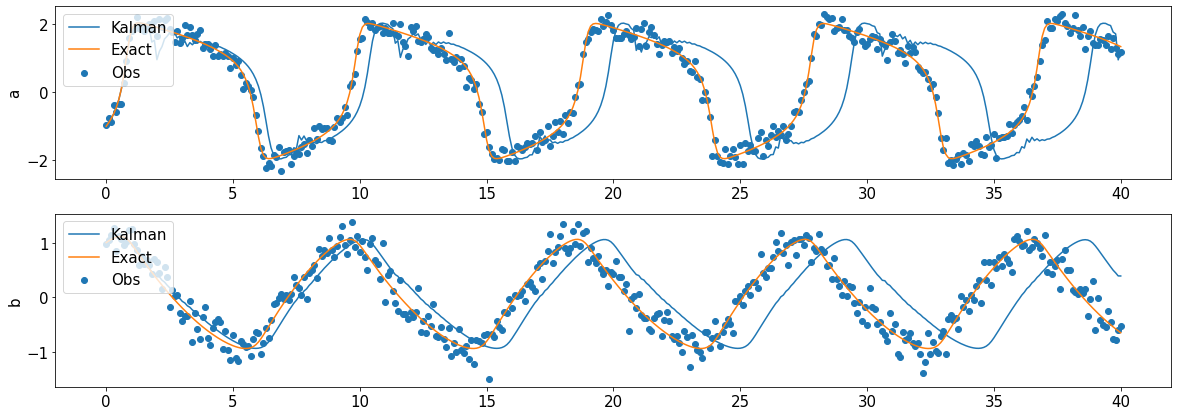

In [30]:
import matplotlib.pyplot as plt
_, axs = plt.subplots(n_dim, 1, figsize=(20, 7))
ylabel = ['a', 'b', 'c']
for i in range(n_dim):
    axs[i].plot(tseq,sim[:,i, 0], label="Kalman")
    #axs[i].plot(tseq, knum_sim[:, n_deriv_prior[0]*i], label="Kalman2")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq1, exact[:, i], label='Exact')
    axs[i].scatter(tseq1, obs[:, i], label='Obs')
    axs[i].legend(loc='upper left')

In [35]:
n_res = 1
n_eval = n_res*n_obs
dt = (tmax-tmin)/n_eval
Omega = (gamma)**2*jnp.ones((2,1,1))
#Omega = jax.vmap(lambda b: sigma[b]*sigma[b]*Omega[b])(jnp.arange(n_obs))
Y = jnp.reshape(exact[1:], newshape=(-1, 2, 1))
# Y = jnp.zeros((n_eval, ))
WW = jnp.array([[[1., 0., 0.]], [[1., 0., 0.]]])
bridge_init = ibm_bridge_init(n_res, dt, n_order, sigma, Y, WW, Omega)

In [36]:
key = jax.random.PRNGKey(0)
sim_jit2 = jax.jit(bsol.solve_forward, static_argnums=(1, 6, 11))
sim2 = sim_jit2(key=key, fun=ode_fun_jax,
        x0=x0_block, theta=thetaj,
        tmin=tmin, tmax=tmax, n_eval=n_eval,
        wgt_meas=W_block, **bridge_init, interrogate=bsol.interrogate_schober
               )

In [37]:
n_order = jnp.array([n_deriv_prior]*n_dim)
ode_init = ibm_init(dt, n_order, sigma)

key = jax.random.PRNGKey(0)
sim_jit1 = jax.jit(osol.solve_forward, static_argnums=(1, 6, 11))
sim1 = sim_jit1(key=key, fun=ode_fun_jax,
        x0=x0_block, theta=thetaj,
        tmin=tmin, tmax=tmax, n_eval=n_eval,
        wgt_meas=W_block, **ode_init, interrogate=osol.interrogate_schober)

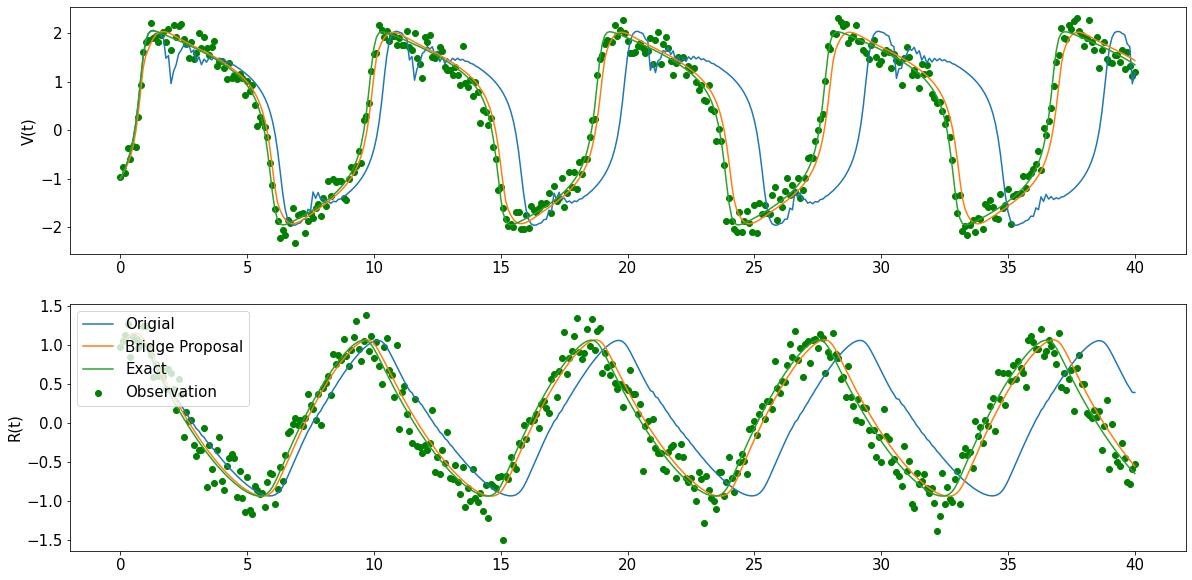

In [38]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(n_dim, 1, figsize=(20, 10))
tseq_sim = np.linspace(tmin, tmax, n_eval+1)
exact_sim = odeint(fitz0, ode0, tseq_sim, args=(theta,))
y_label = ['V(t)', 'R(t)']
plt.rcParams.update({'font.size': 15})
for i in range(n_dim):
    axs[i].plot(tseq_sim,sim1[:,i, 0], label="Origial")
    axs[i].plot(tseq_sim,sim2[:,i, 0], label="Bridge Proposal")
    axs[i].plot(tseq_sim, exact_sim[:, i], label='Exact')
    axs[i].scatter(tseq1, obs[:, i], label='Observation', color='green')
    axs[i].set_ylabel(y_label[i])
axs[1].legend(loc='upper left')
fig.savefig("plot.png")


In [66]:
n_sim = 10
xn = jnp.zeros((n_sim, n_eval+1, 3))
xn = xn.at[:, 0].set(x0_block[0])
Q = ode_init['wgt_state'][0]
R = ode_init['var_state'][0]

In [67]:
key = jax.random.PRNGKey(1)
for i in range(n_sim):
    key, *subkeys = jax.random.split(key, num=n_eval+1)
    for j in range(n_eval):
        xn = xn.at[i, j+1].set(jax.random.multivariate_normal(subkeys[j], Q.dot(xn[i, j]), R))

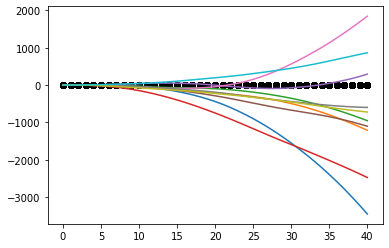

In [49]:
for i in range(n_sim):
    plt.plot(tseq, xn[i, :, 0])
    plt.scatter(tseq, obs[:, 0], color='black')

In [68]:
n_sim = 10
xn = jnp.zeros((n_sim, n_eval+1, 3))
#xn[:, 0] = x0_block[0]
xn = xn.at[:, 0].set(x0_block[0])
Qn = bridge_init['wgt_state'][:, 0]
Rn = bridge_init['var_state'][:, 0]
cn = bridge_init['mu_state'][:, 0]

In [69]:
key = jax.random.PRNGKey(1)
for i in range(n_sim):
    key, *subkeys = jax.random.split(key, num=n_eval+1)
    for j in range(n_eval):
        if np.isclose(Rn[j][0,0], 0):
            xn = xn.at[i, j+1].set(Qn[j].dot(xn[i, j]) + cn[j])
        #xn[i, j+1] = jax.random.multivariate_normal(key, Qn[j].dot(xn[i, j]) + cn[j], Rn[j])
        else:
            xn = xn.at[i, j+1].set(jax.random.multivariate_normal(subkeys[j], Qn[j].dot(xn[i, j]) + cn[j], Rn[j]))

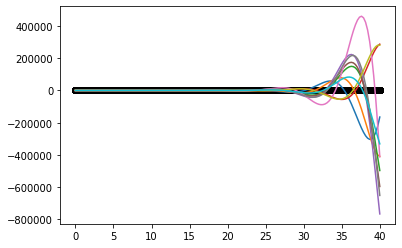

In [70]:
for i in range(n_sim):
    plt.plot(tseq, xn[i, :, 0])
    plt.scatter(tseq, obs[:, 0], color='black')

In [54]:
import rodeo.jax.kalmantv as ktv

n_eval = 150

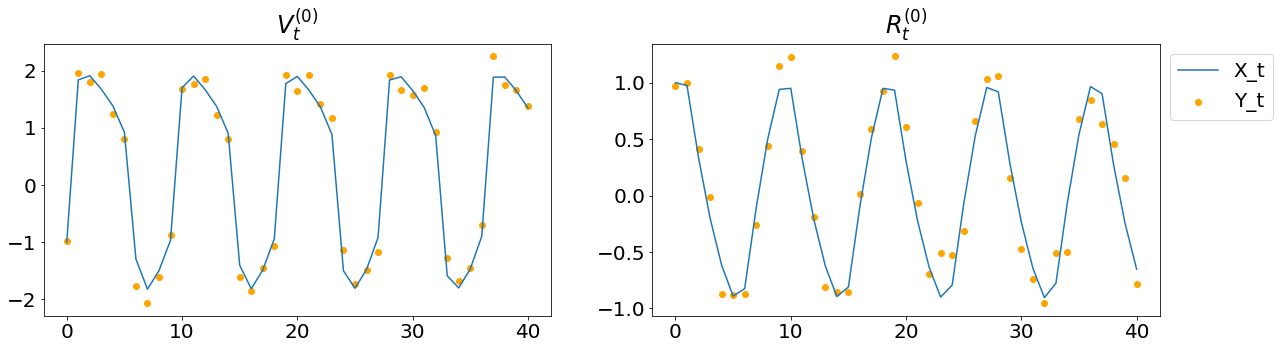

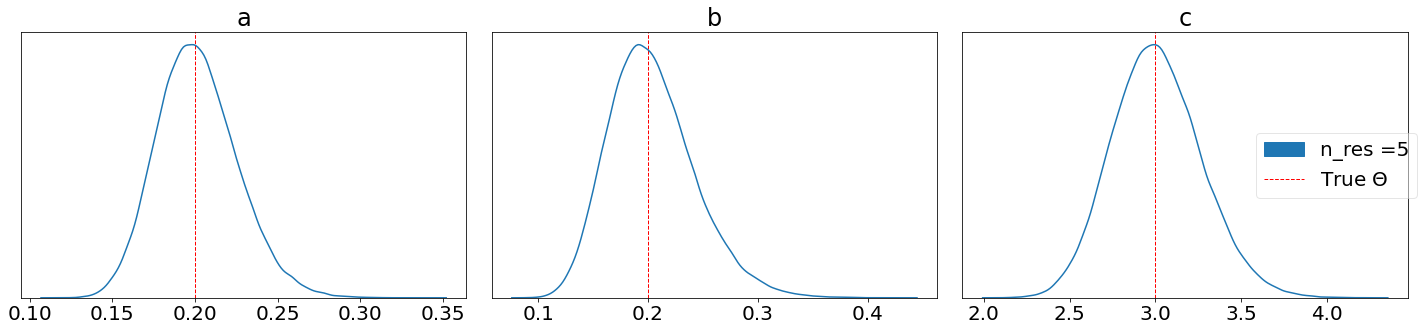

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from inference.fitzinf import fitzinf as inference
from rodeo.jax.ibm_init import ibm_init
from rodeo.jax.ode_solve import *
from rodeo.jax.ibm_bridge_init import ibm_bridge_init
import rodeo.jax.ode_bridge_solve as bsol

def fitz(X_t, t, theta):
    "Fitz ODE written for jax"
    a, b, c = theta
    V, R = X_t[:, 0]
    return jnp.array([[c*(V - V*V*V/3 + R)],
                      [-1/c*(V - a + b*R)]])

def fitzpad(X_t, t, theta):
    a, b, c = theta
    p = len(X_t)//2
    V, R = X_t[0], X_t[p]
    return jnp.array([[V, c*(V - V*V*V/3 + R), 0],
                      [R, -1/c*(V - a + b*R), 0]])


def fitz_example(load_calcs=False):
    "Perform parameter inference using the FitzHugh-Nagumo function."
    # These parameters define the order of the ODE and the CAR(p) process
    n_deriv = 1 # number of derivatives in IVP
    n_dim = 2 # number of observations.
    n_deriv_prior = 3 # number of derivatives in IBM prior

    # it is assumed that the solution is sought on the interval [tmin, tmax].
    tmin = 0.
    tmax = 40.

    # The rest of the parameters can be tuned according to ODE
    # For this problem, we will use
    sigma = jnp.array([1]*n_dim)
    n_order = jnp.array([n_deriv_prior]*n_dim)

    # Initial value, x0, for the IVP
    x0 = np.array([-1., 1.])
    v0 = np.array([1, 1/3])
    X0 = np.ravel([x0, v0], 'F')

    # pad the inputs
    W_mat = np.zeros((n_dim, 1, n_deriv_prior))
    W_mat[:, :, 1] = 1
    W = jnp.array(W_mat)

    # logprior parameters
    theta_true = np.array([0.2, 0.2, 3]) # True theta
    n_theta = len(theta_true)
    phi_mean = np.zeros(n_theta)
    phi_sd = np.log(5)*np.ones(n_theta) 

    # Observation noise
    gamma = 0.2
    Omega = gamma**2*jnp.ones((2,1,1))
    WW = jnp.array([[[1., 0., 0.]], [[1., 0., 0.]]])

    # Number of samples to draw from posterior
    n_samples = 100000

    # Initialize inference class and simulate observed data
    key = jax.random.PRNGKey(0)
    inf = inference(key, tmin, tmax, fitz)
    inf.funpad = fitzpad
    tseq = np.linspace(tmin, tmax, 41)
    Y_t, X_t = inf.simulate(x0, theta_true, gamma, tseq)
    Y_bridge = jnp.reshape(Y_t[1:], newshape=(-1, 2, 1))

    plt.rcParams.update({'font.size': 20})
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(tseq, X_t[:,0], label = 'X_t')
    axs[0].scatter(tseq, Y_t[:,0], label = 'Y_t', color='orange')
    axs[0].set_title("$V^{(0)}_t$")
    axs[1].plot(tseq, X_t[:,1], label = 'X_t')
    axs[1].scatter(tseq, Y_t[:,1], label = 'Y_t', color='orange')
    axs[1].set_title("$R^{(0)}_t$")
    axs[1].legend(loc='upper left', bbox_to_anchor=[1, 1])
    #fig.savefig('figures/fitzsim.pdf')
    
    n_res = np.array([5])
    obs_t = 1
    n_obs = 40
    if load_calcs:
        theta_bridge = np.load('saves/fitz_theta_bridge.npy')
#         theta_kalman = np.load('saves/fitz_theta_kalman2.npy')
        theta_diffrax = np.load('saves/fitz_theta_diffrax.npy')
    else:
        # Parameter inference using Kalman solver
#         phi_init = np.append(np.log(theta_true), x0)
        phi_init = np.log(theta_true)
#         theta_kalman = np.zeros((len(n_res), n_samples, n_theta))
#         for i in range(len(n_res)):
#             print(i)
#             n_eval = int(n_obs*n_res[i])
#             dt = (tmax-tmin)/n_eval
#             kinit = ibm_init(dt, n_order, sigma)
#             inf.n_eval = n_eval
#             inf.kinit = kinit
#             inf.W = W
#             phi_hat, phi_var = inf.phi_fit(Y_t, x0, dt, obs_t, phi_mean, phi_sd, inf.kalman_nlpost,
#                                            gamma, phi_init = phi_init,method="Newton-CG")
#             theta_kalman[i] = inf.phi_sample(phi_hat, phi_var, n_samples)
#             theta_kalman[i, :, :n_theta] = np.exp(theta_kalman[i, :, :n_theta])
#         np.save('saves/fitz_theta_kalman2.npy', theta_kalman)

        theta_bridge = np.zeros((len(n_res), n_samples, n_theta))
        for i in range(len(n_res)):
            print(i)
            n_eval = int(n_obs*n_res[i])
            dt = (tmax-tmin)/n_eval
            bridge_init = ibm_bridge_init(n_res[i], dt, n_order, sigma, Y_bridge, WW, Omega)
            inf.n_eval = n_eval
            inf.kinit = bridge_init
            inf.W = W
            phi_hat, phi_var = inf.phi_fit(Y_t, x0, dt, obs_t, phi_mean, phi_sd, inf.bridge_nlpost,
                                           gamma, phi_init = phi_init)
            theta_bridge[i] = inf.phi_sample(phi_hat, phi_var, n_samples)
            theta_bridge[i, :, :n_theta] = np.exp(theta_bridge[i, :, :n_theta])
        np.save('saves/fitz_theta_bridge.npy', theta_bridge)
#         # Parameter inference using diffrax
#         phi_hat, phi_var = inf.phi_fit(Y_t, np.array([None, None]), dt, obs_t, phi_mean, phi_sd, inf.diffrax_nlpost,
#                                       gamma, phi_init = phi_init)
#         theta_diffrax = inf.phi_sample(phi_hat, phi_var, n_samples)
#         theta_diffrax[:, :n_theta] = np.exp(theta_diffrax[:, :n_theta])
        theta_diffrax = np.load('saves/fitz_theta_diffrax.npy')
        #np.save('saves/fitz_theta_diffrax.npy', theta_diffrax)
        
    # Produces the graph in Figure 3
    plt.rcParams.update({'font.size': 20})
    var_names = ['a', 'b', 'c']
    param_true = np.append(theta_true, np.array([-1, 1]))
#     figure = inf.theta_plot(theta_kalman, theta_bridge, theta_diffrax, param_true, n_res, var_names, clip=[None, (0, 0.5), None, None, None], rows=1)
    #figure.savefig('figures/fitzfigure3.pdf')
    figure = inf.theta_plotsingle(theta_bridge, theta_diffrax, param_true, n_res, var_names, clip=[None, (0, 0.5), None, None, None], rows=1)
    figure.savefig('figures/fitzfigure4.png')
    plt.show()
    return

if __name__ == '__main__':
    fitz_example(True)
    

In [136]:
a= -100
def ode_exp(X_t, t, theta):
    return a*X_t[:, 0]

def ode_exp0(X_t, t, theta):
    return a*X_t

In [167]:
# problem setup and intialization
n_deriv = 1  # Total state
n_obs = 1  # Total measures
n_deriv_prior = 3

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 100
tmin = 0.
tmax = .1

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = 0.1
sigma = jnp.array([sigma]*n_obs)

# Initial value, x0, for the IVP
W_mat = np.zeros((n_obs, 1, n_deriv_prior))
W_mat[:, :, 1] = 1
W_block = jnp.array(W_mat)

# Initial x0 for odeint
ode0 = np.array([1.])

# Initial x0 for jax block
#x0_block = jnp.array([[-1., 1., 1.], [1., 1/3, -0.3555555555555555]])
x0_block = jnp.array([[1.0, a, 0.]])

# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
n_order = jnp.array([n_deriv_prior]*n_obs)
ode_init = ibm_init(dt, n_order, x0_block, sigma)
# ode_init['mu_state']= jnp.concatenate([jax.random.normal(key,shape=(2,1)), jnp.zeros((2,2))], axis=1)
ode_init['mu_state'] = jnp.zeros((1,3))

key = jax.random.PRNGKey(0)
sim_jit = jax.jit(osol.solve_forward, static_argnums=(1, 6, 11))
sim1 = sim_jit(key=key, fun=ode_exp,
        x0=x0_block, theta=None,
        tmin=tmin, tmax=tmax, n_eval=n_eval,
        wgt_meas=W_block, **ode_init, interrogate=interrogate_rodeo)

In [168]:
x0_block = jnp.array([[1.0, a, a**2]])
ode_init = ibm_init(dt, n_order, x0_block, sigma)
ode_init['mu_state'] = jnp.zeros((1,3))
sim2 = sim_jit(key=key, fun=ode_exp,
        x0=x0_block, theta=None,
        tmin=tmin, tmax=tmax, n_eval=n_eval,
        wgt_meas=W_block, **ode_init, interrogate=interrogate_rodeo)

In [169]:
from scipy.integrate import odeint
import numpy as np
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(ode_exp0, ode0, tseq, args=(None,))

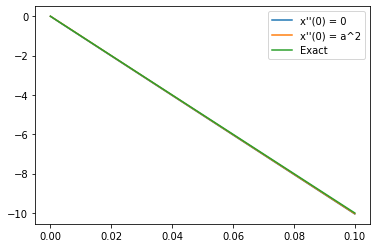

In [170]:
import matplotlib.pyplot as plt

plt.plot(tseq, jnp.log(sim1[:,0, 0]), label="x''(0) = 0")
plt.plot(tseq, jnp.log(sim2[:,0, 0]), label="x''(0) = a^2")

plt.plot(tseq, jnp.log(exact[:, 0]), label='Exact')
plt.legend(loc='upper right')